# Анализ данных NGS. Домашнее задание № 1

Выполнил: Олег Вавулов

In [1]:
import gzip
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import njit
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import product
from Bio.Seq import Seq

In [2]:
with open("./data/test3.fastq", "r", encoding="ascii") as f:
    test = f.read()

In [4]:
%%time
with open("../../data/hw_1/100x.1.fastq.gz", "rb") as f:
     forward = gzip.decompress(f.read()).decode("ascii")
with open("../../data/hw_1/100x.2.fastq.gz", "rb") as f:
     reverse = gzip.decompress(f.read()).decode("ascii")

CPU times: user 7.44 s, sys: 1.21 s, total: 8.65 s
Wall time: 8.66 s


## 1. GC состав

In [5]:
def get_sequences(fastq):
    """
    Извлекаем последовательности из fastq текста
    """
    lines = fastq.split("\n")
    seqs = [lines[i] for i in range(len(lines)) if i % 4 == 1]
    lengths = [len(seq) for seq in seqs]
    if len(np.unique(lengths)) > 1:
        print("Different read legth!")
    else:
        print(f"Read length is {lengths[0]}")
    return seqs, lengths

def get_GC_content(fastq):
    """
    Считаем долю GC по всей библиотеке и по каждому риду
    """
    seqs, lengths = get_sequences(fastq)
    gc_total = 0
    gc_ratio = []
    for seq, length in tqdm(zip(seqs, lengths)):
        gc_read = 0
        for nt in seq:
            gc_read += nt == "C" or nt == "G"
        gc_total += gc_read
        gc_ratio.append(100*gc_read/length)
    return gc_total/sum(lengths), pd.Series(gc_ratio)

In [6]:
gc_content_fw, gc_distribution_fw = get_GC_content(forward)
print(f"\nResults:\nGC content (forward): {gc_content_fw:.2f}\n")

14872it [00:00, 148690.36it/s]

Read length is 100


2500000it [00:17, 142771.83it/s]



Results:
GC content (forward): 0.51



In [7]:
gc_content_rv, gc_distribution_rv = get_GC_content(reverse)
print(f"\nResults:\nGC content (reverse): {gc_content_rv:.2f}\n")

13022it [00:00, 130213.60it/s]

Read length is 100


2500000it [00:17, 142986.13it/s]



Results:
GC content (reverse): 0.51



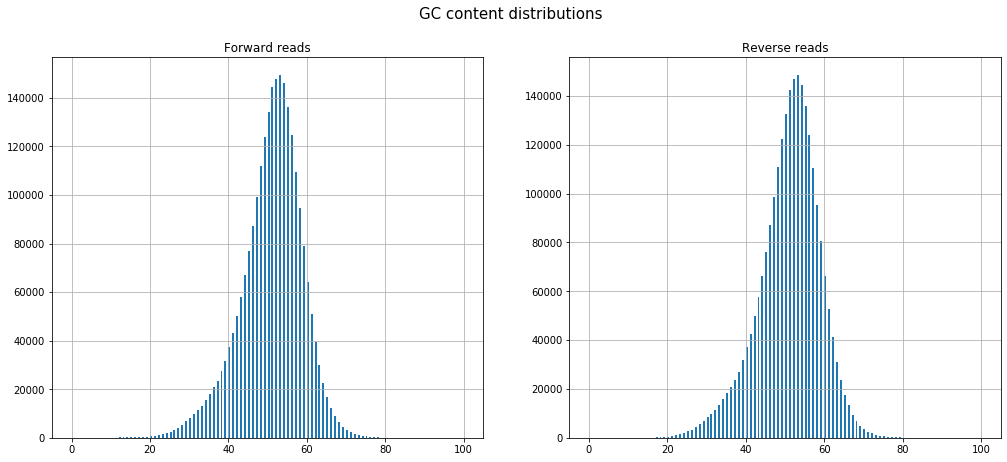

In [8]:
N_BINS = 200
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))
f.suptitle("GC content distributions", fontsize=15)
gc_distribution_fw.hist(bins=N_BINS, ax=ax[0])
gc_distribution_rv.hist(bins=N_BINS, ax=ax[1])
ax[0].set_title("Forward reads")
ax[1].set_title("Reverse reads");

## 2. Распределение качества

Вероятность ошибки будем получать из Phred quality score по следующей формуле

$$P = 10^{-\frac{Q}{10}}$$

In [46]:
def get_qualities(fastq):
    """
    Извлекаем качество ридов из fastq текста
    """
    lines = fastq.split("\n")
    seqs, lengths = get_sequences(fastq)
    quals = np.zeros((len(seqs), max(lengths))) + np.inf
    # вытаскиваем качество из fastq и переводим из ascii в байты
    quals_raw = [[ord(ch) for ch in lines[i]] for i in range(len(lines)) if i % 4 == 3]
    for i in range(len(quals_raw)):
        quals[i, :len(quals_raw[i])] = quals_raw[i]
    # определяем шкалу Phred по минимальному качеству
    scale = 64 if quals.min() > 64 else 33
    # расчитываем вероятности ошибки
    quals = np.where(quals != np.inf, 10**((quals - scale)*-0.1), quals)
    mean_quals = []
    # усредняем по позиции
    for i in range(quals.shape[1]):
        pos_quals = quals[:, i]
        mean_quals.append(pos_quals[pos_quals != np.inf].mean())
    return mean_quals

In [47]:
%%time
quality_distr_fw = get_qualities(forward)

Read length is 100
CPU times: user 1min 8s, sys: 11.5 s, total: 1min 19s
Wall time: 1min 14s


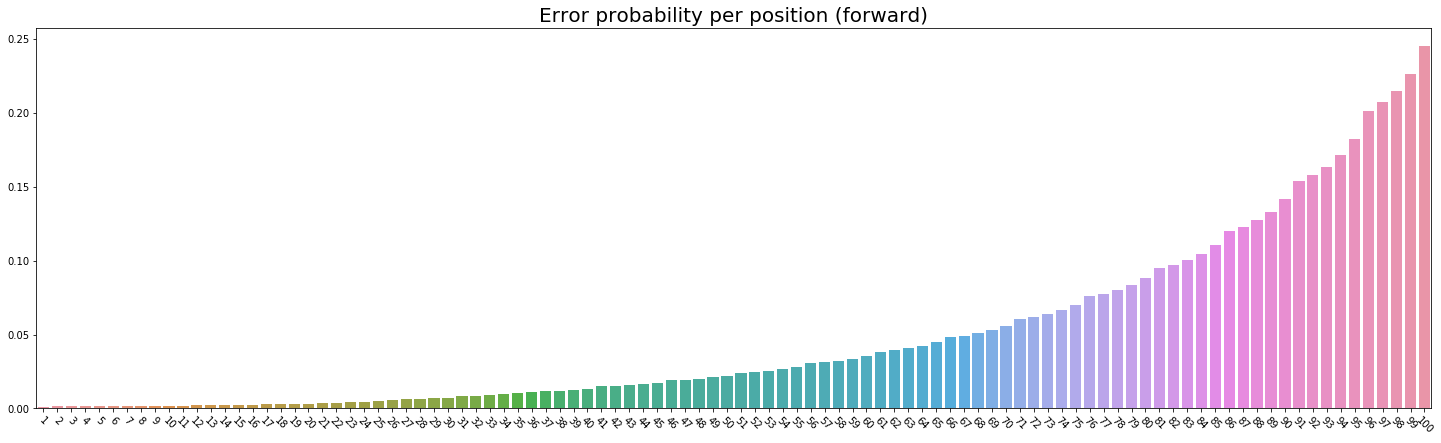

In [48]:
plt.figure(figsize=(25, 7))
ax = sns.barplot(x=list(range(1, len(quality_distr_fw)+1)), y=quality_distr_fw)
ax.set_title("Error probability per position (forward)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-45);

In [49]:
%%time
quality_distr_rv = get_qualities(reverse)

Read length is 100
CPU times: user 1min 7s, sys: 10.8 s, total: 1min 18s
Wall time: 1min 12s


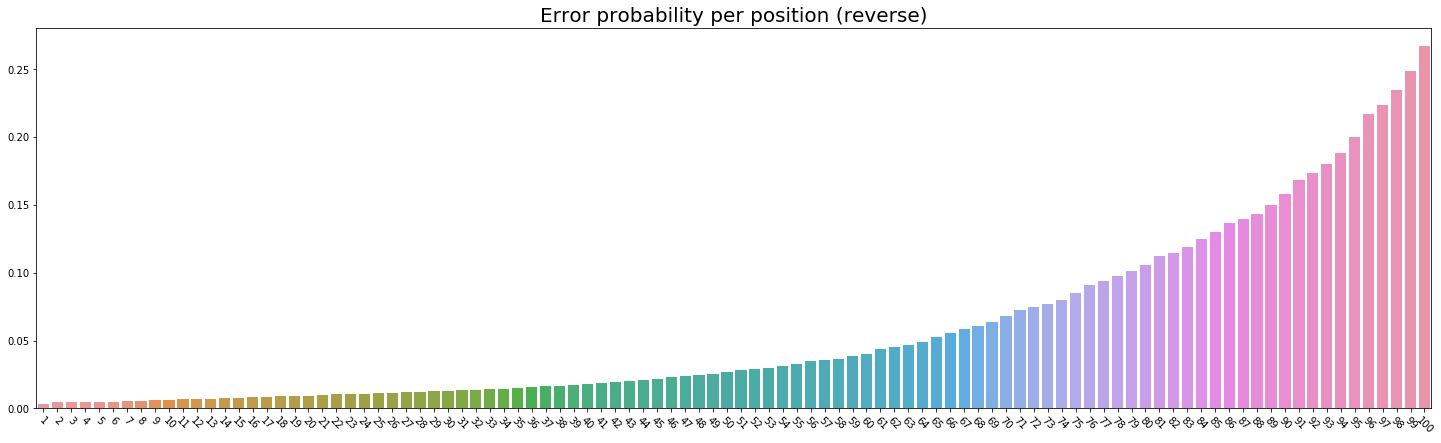

In [50]:
plt.figure(figsize=(25, 7))
ax = sns.barplot(x=list(range(1, len(quality_distr_rv)+1)), y=quality_distr_rv)
ax.set_title("Error probability per position (reverse)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=-45);

## 3. Проверка результатов

Доля GC для прямых ридов (100x.1_fastqc)

<img src="fastqc/gc_fw.png" width=600 height=600 />

Доля GC для обратных ридов (100x.2_fastqc)

<img src="fastqc/gc_rv.png" width=600 height=600 />

Распределение качества для прямых ридов (100x.1_fastqc)

<img src="fastqc/qual_fw.png" width=600 height=600 />

Распределение качества для обратных ридов (100x.2_fastqc)

<img src="fastqc/qual_rv.png" width=600 height=600 />

В целом получившиеся графики соответсвуют результатам fastqc

## 4. Спектры k-меров

In [16]:
def get_kmers_distr(fastq, k=2):
    seqs, read_len = get_sequences(fastq)
    kmers = ["".join(kmer) for kmer in product(*[list("ACTG")]*k)]    
    kmers = dict.fromkeys(kmers, 0)
    for seq in tqdm(seqs):
        for kmer in kmers.keys():
            kmers[kmer] += Seq("".join(seq)).count_overlap(kmer)
    return kmers

In [17]:
%%time
kmers = get_kmers_distr(forward + reverse)

  0%|          | 3101/5000000 [00:00<05:31, 15094.35it/s]

Read length is 100


100%|██████████| 5000000/5000000 [05:15<00:00, 15867.40it/s]


CPU times: user 5min 18s, sys: 3.33 s, total: 5min 22s
Wall time: 5min 20s


In [18]:
kmers

{'AA': 35860593,
 'AC': 27248851,
 'AT': 32631393,
 'AG': 24934960,
 'CA': 34107418,
 'CC': 29488768,
 'CT': 25465419,
 'CG': 36422446,
 'TA': 22526781,
 'TC': 28503046,
 'TT': 36998276,
 'TG': 34113031,
 'GA': 28009982,
 'GC': 40325233,
 'GT': 27040135,
 'GG': 30347222}

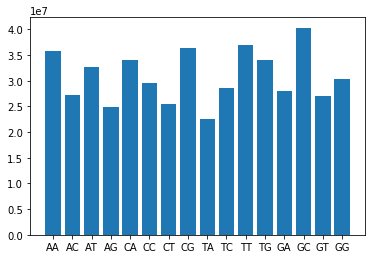

In [19]:
plt.bar(kmers.keys(), kmers.values());